In [1]:
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from tqdm import tqdm

### Configuration

In [2]:
DATA_DIR="../data/"
PROTEOME_NAME="UP000005640_9606"

In [3]:
PLDDT_SCORES_JSON=os.path.join(DATA_DIR,f"{PROTEOME_NAME}_HUMAN_v3_plddts_fltrd.json")
SETH_SCORES_FASTA=os.path.join(DATA_DIR,"Human_SETH_preds.txt")
NEFF_GPU_SCORES_JSON=os.path.join(DATA_DIR,f"{PROTEOME_NAME}_neff_fast.json")
NEFF_MMSEQS_SCORES_JSON=os.path.join(DATA_DIR,f"{PROTEOME_NAME}_neff_mmseqs.json")

In [4]:
colors = sns.color_palette("colorblind")
colors

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

### Load scores

Per-protein per-residue scores for each metric.

In [5]:
# load pLDDT scores
with open(PLDDT_SCORES_JSON) as f:
    plddt = json.load(f)
    plddt = {p:torch.tensor(xs) for p,xs in plddt.items()}
print(len(plddt), "plddt scores loaded")

20296 plddt scores loaded


In [6]:
# load SETH scores
with open(SETH_SCORES_FASTA) as f:
    seth = {}
    lines = f.readlines()
    for hdr,scores in zip(lines[::2],lines[1::2]):
        hdrid=hdr.split("|")[1]
        score=torch.tensor([float(s) for s in scores.split(", ")])
        seth[hdrid]=score
print(len(seth), "SETH scores loaded")

20352 SETH scores loaded


In [7]:
# load Neff gpu scores
with open(NEFF_GPU_SCORES_JSON) as f:
    neff_gpu = json.load(f)
    neff_gpu = {p:torch.tensor(xs) for p,xs in neff_gpu.items()}
print(len(neff_gpu), "neff gpu scores loaded")

18741 neff gpu scores loaded


In [8]:
# load Neff mmseqs scores
with open(NEFF_MMSEQS_SCORES_JSON) as f:
    neff_mmseqs = json.load(f)
    neff_mmseqs = {p:torch.tensor(xs) for p,xs in neff_mmseqs.items()}
print(len(neff_mmseqs), "neff mmseqs scores loaded")

20600 neff mmseqs scores loaded


### Find consistent proteins

Only correlate metrics for which we have data for all proteins. Data means that every dataset contains the protein and the proteins have the same lengths across all datasets.

In [9]:
shared_ids = set(plddt) & set(seth) & set(neff_gpu) & set(neff_mmseqs)
print("found", len(shared_ids), "ids that are present in all datasets")

found 18319 ids that are present in all datasets


In [10]:
lenagree_ids = []
for protid in shared_ids:
    if len(plddt[protid]) == len(seth[protid]) == len(neff_gpu[protid]) == len(neff_mmseqs[protid]):
        lenagree_ids.append(protid)
print("found", len(lenagree_ids), "proteins with agreeing lengths")

found 18271 proteins with agreeing lengths


In [11]:
# only retain scores that are present in all 3 datasets for convinience
ids = lenagree_ids
plddt = {p:xs for p,xs in plddt.items() if p in ids}
seth = {p:xs for p,xs in seth.items() if p in ids}
neff_gpu = {p:xs for p,xs in neff_gpu.items() if p in ids}
neff_mmseqs = {p:xs for p,xs in neff_mmseqs.items() if p in ids}
len(neff_gpu),len(neff_mmseqs),len(seth),len(plddt),len(ids)

(18271, 18271, 18271, 18271, 18271)

### Analysis

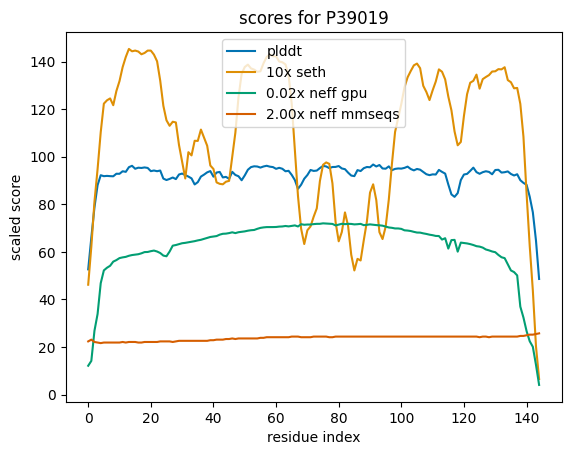

In [15]:
def showscores(protid,sethscale=10.,neff_gpu_scale=.02,neff_mmseqs_scale=2.):
    plt.plot(plddt[protid],label="plddt",color=colors[0])
    plt.plot(sethscale*seth[protid],label="%.0fx seth" % sethscale,color=colors[1])
    plt.plot(neff_gpu_scale*neff_gpu[protid],label="%.02fx neff gpu" % neff_gpu_scale,color=colors[2])
    plt.plot(neff_mmseqs_scale*neff_mmseqs[protid],label="%.02fx neff mmseqs" % neff_mmseqs_scale,color=colors[3])
    plt.xlabel("residue index")
    plt.ylabel("scaled score")
    plt.legend()
    plt.title("scores for %s" % protid)
testid = list(ids)[100]
showscores(testid)

In [16]:
corrs = {}
scores = {"plddt":plddt,"seth":seth,"neff gpu":neff_gpu,"neff mmseqs":neff_mmseqs}
score2id = {s:i for i,s in enumerate(scores.keys())}
id2score = {i:s for s,i in score2id.items()}
for protid in tqdm(ids,desc="calculating pairwise correlations"):
    st = torch.stack(tuple(score[protid] for score in scores.values()))
    # see if covariance matrix contains zero entries on the diagonal since
    # these would lead to nan entries in the correlation matrix.
    # here, these matrices are set to zeros because there is no variance.
    if len(torch.diag(torch.cov(st)).nonzero()) == len(scores):
        corrs[protid] = torch.corrcoef(st)
    else:
        #print("zero cov for prot",protid)
        corrs[protid] = torch.zeros((len(scores),)*2)

calculating pairwise correlations:  13%|██              | 2376/18271 [00:00<00:01, 11887.90it/s]

zero cov for prot A0A0A0MTA7
zero cov for prot Q9BTD1
zero cov for prot A0A0A0MT94
zero cov for prot Q0VDD5
zero cov for prot A0A0J9YXG5
zero cov for prot Q0VG73
zero cov for prot Q8TAB7
zero cov for prot Q9BZS9
zero cov for prot O75897


calculating pairwise correlations:  20%|███▎             | 3565/18271 [00:00<00:01, 8790.85it/s]

zero cov for prot O43653
zero cov for prot A0A075B6S0
zero cov for prot Q9HBX3
zero cov for prot Q8IVK1


calculating pairwise correlations:  32%|█████           | 5851/18271 [00:00<00:01, 10206.98it/s]

zero cov for prot P20160
zero cov for prot J3KSC0
zero cov for prot A0A0J9YWP8
zero cov for prot O00338
zero cov for prot Q75NE6
zero cov for prot Q9Y3F1
zero cov for prot Q9Y5K2


calculating pairwise correlations:  45%|███████▏        | 8189/18271 [00:00<00:00, 11018.27it/s]

zero cov for prot Q6IMI4
zero cov for prot A0A075B700
zero cov for prot Q0P140
zero cov for prot Q9BQT8
zero cov for prot A0A0C5B5G6
zero cov for prot Q96MF0


calculating pairwise correlations:  58%|████████▋      | 10569/18271 [00:00<00:00, 11467.60it/s]

zero cov for prot Q8WZA8
zero cov for prot Q9Y2X8
zero cov for prot Q9H0P7
zero cov for prot Q9BVJ7
zero cov for prot Q96IR3
zero cov for prot P11802
zero cov for prot A0A0B4J200
zero cov for prot P0DP58
zero cov for prot Q15661


calculating pairwise correlations:  78%|███████████▋   | 14164/18271 [00:01<00:00, 11811.81it/s]

zero cov for prot P0C841
zero cov for prot O43704
zero cov for prot Q96QG7
zero cov for prot P61077
zero cov for prot Q15493


calculating pairwise correlations:  91%|█████████████▌ | 16545/18271 [00:01<00:00, 11826.02it/s]

zero cov for prot Q9UJ94
zero cov for prot Q8TCZ7
zero cov for prot P51668
zero cov for prot P62837
zero cov for prot Q49A17
zero cov for prot Q9GZZ1


calculating pairwise correlations: 100%|███████████████| 18271/18271 [00:01<00:00, 11242.36it/s]

zero cov for prot Q9P1D8
zero cov for prot A0A0J9YWX3
zero cov for prot P20231


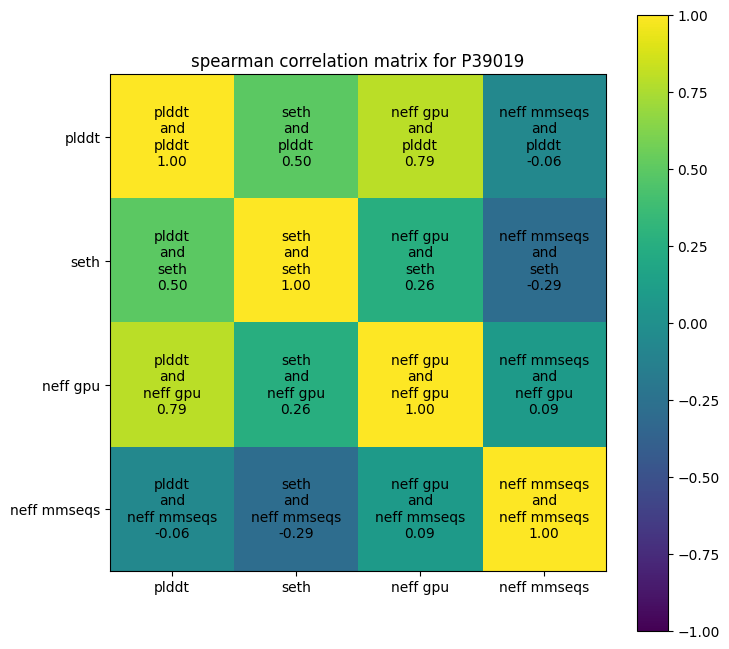

In [17]:
def showcorr(corrmat,name,prefix="",lims=(-1,1)):
    """show correlation between scores"""
    plt.figure(figsize=(8,8))
    plt.imshow(corrmat)
    plt.colorbar()
    plt.title("%sspearman correlation matrix for %s" % (prefix,name))
    plt.xticks(range(len(scores.keys())),scores.keys())
    plt.yticks(range(len(scores.keys())),scores.keys())
    if lims is not None:
        plt.clim(*lims)
    for x,l1 in enumerate(scores.keys()):
        for y,l2 in enumerate(scores.keys()):
            val = corrmat[x][y].item()
            plt.text(x,y,"%s\nand\n%s\n%.02f" % (l1,l2,val),ha="center",va="center")
showcorr(corrs[testid], name=testid)

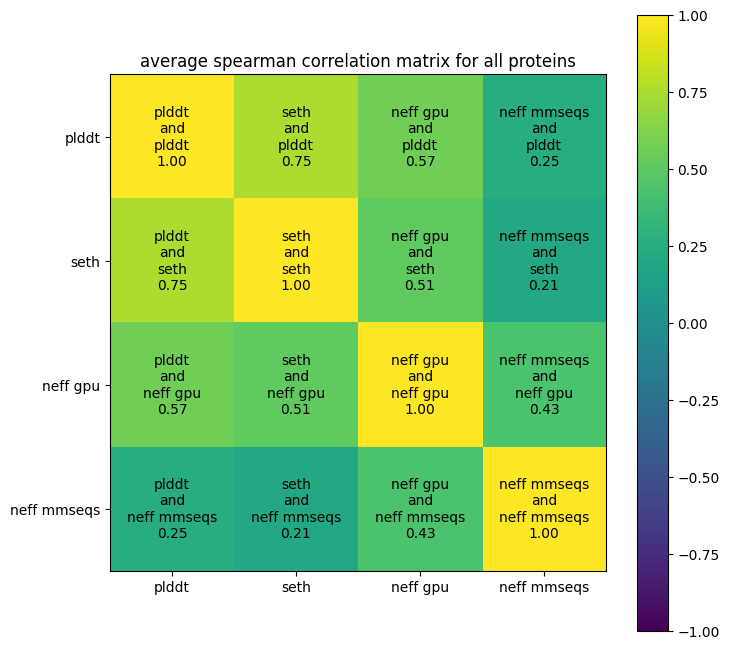

In [18]:
corrstack = torch.stack(tuple(corrs.values()))
corrstd, corravg = torch.std_mean(corrstack,dim=0)
showcorr(corravg, name="all proteins", prefix="average ")

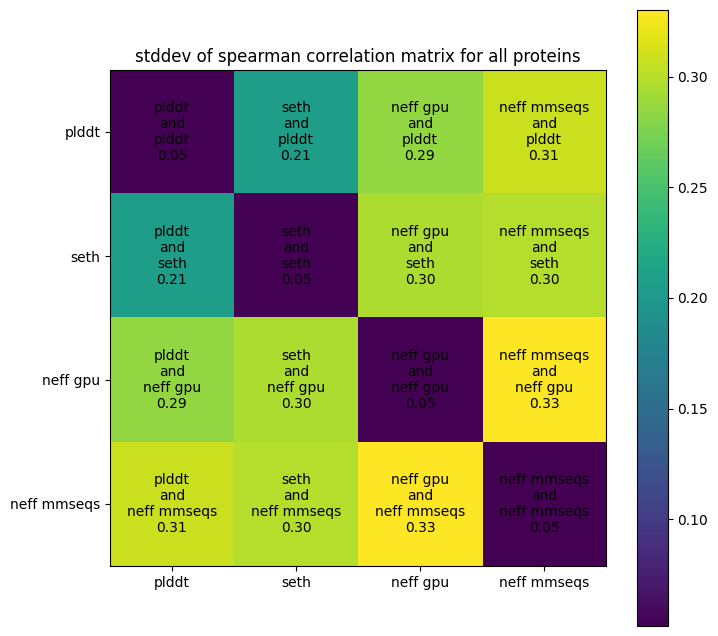

In [20]:
# TODO: why is the diagonal filled with .05???
showcorr(corrstd, name="all proteins", prefix="stddev of ", lims=None)

### Find outliers

In [21]:
neffid,plddtid = score2id["neff gpu"],score2id["plddt"]

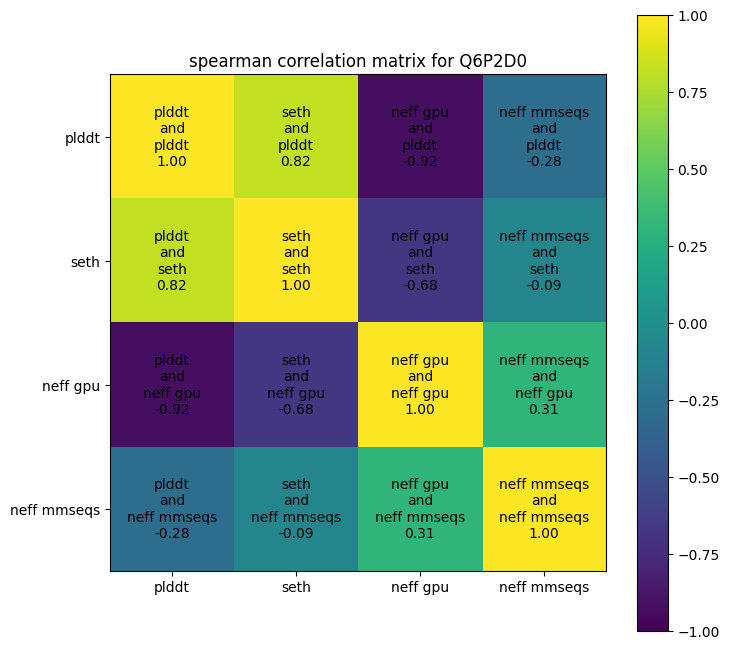

In [22]:
minid,minval = None,float("inf")
for protid in ids:
    val = corrs[protid][neffid,plddtid].item()
    if minval > val:
        minval = val
        minid  = protid
showcorr(corrs[minid],minid)

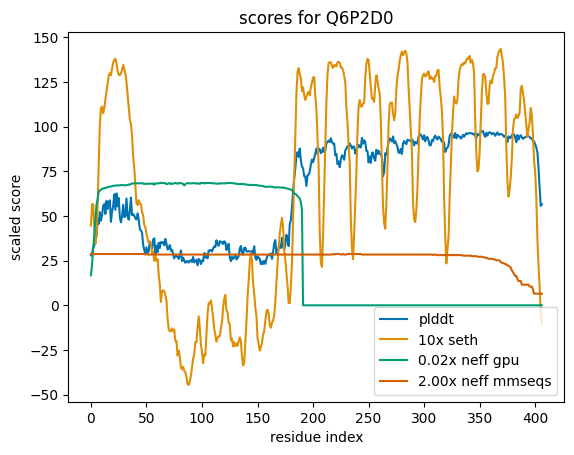

In [23]:
showscores(minid)

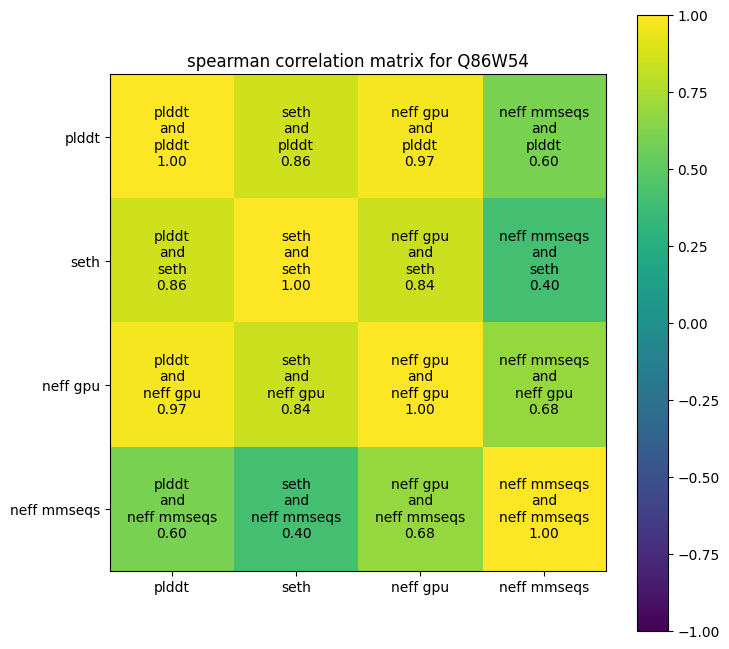

In [24]:
maxid,maxval = None,float("-inf")
for protid in ids:
    val = corrs[protid][neffid,plddtid].item()
    if maxval < val:
        maxval = val
        maxid  = protid
showcorr(corrs[maxid],maxid)

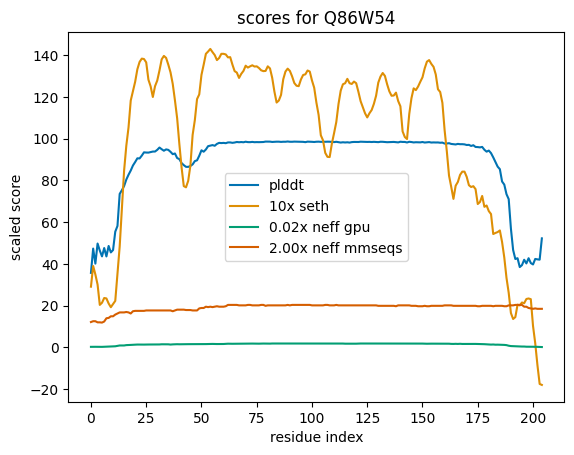

In [25]:
showscores(maxid)

### Bin scores

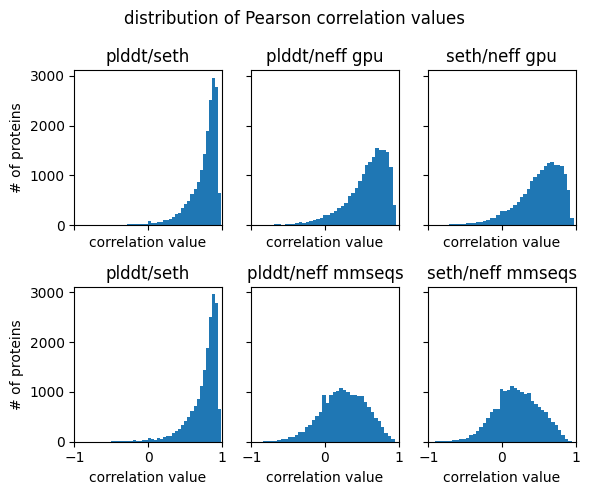

In [44]:
pairs = [
    [("plddt","seth"),("plddt","neff gpu"),("seth","neff gpu")],
    [("plddt","seth"),("plddt","neff mmseqs"),("seth","neff mmseqs")],
]
idpairs = [[(score2id[s1],score2id[s1]) for s1,s2 in p] for p in pairs]
fig,axss = plt.subplots(ncols=len(pairs[0]),nrows=2,figsize=(6,5),sharey=True,sharex=True)
for rowidx,r in enumerate(["neff gpu","neff mmseqs"]):
    axs = axss[rowidx]
    for colidx,(ax,p) in enumerate(zip(axs,pairs[rowidx])):
        if colidx == 0:
            ax.set_ylabel("# of proteins")
        
        s1,s2 = p
        id1,id2 = score2id[s1],score2id[s2]

        ax.hist(corrstack[:,id1,id2].sort()[0],bins=40)
        ax.set_title("%s/%s" % p)
        ax.set_xlabel("correlation value")
        ax.set_xlim(-1,1)
fig.suptitle("distribution of Pearson correlation values")
fig.tight_layout()

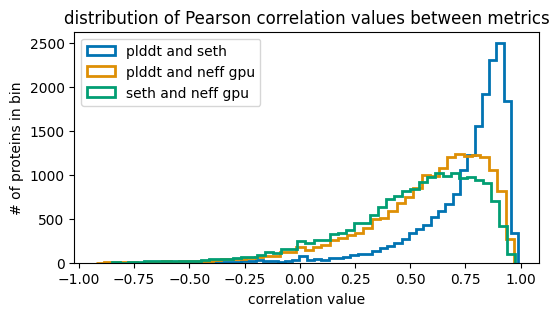

In [45]:
pairs = [("plddt","seth"),("plddt","neff gpu"),("seth","neff gpu")]
plt.figure(figsize=(6,3))
for i,(ax,p) in enumerate(zip(axs,pairs)):
    s1,s2 = p
    id1,id2 = score2id[s1],score2id[s2]
    plt.hist(corrstack[:,id1,id2].sort()[0],bins=50,label="%s and %s" % p,histtype="step",lw=2,color=colors[i])
#plt.axvline(0,label="no correlation",c="k",ls=":")
plt.xlabel("correlation value")
plt.ylabel("# of proteins in bin")
plt.title("distribution of Pearson correlation values between metrics")
plt.legend(loc="upper left")

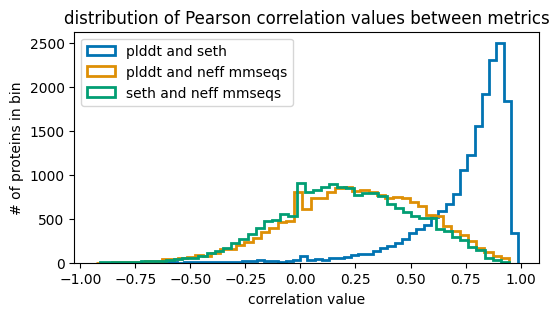

In [46]:
pairs = [("plddt","seth"),("plddt","neff mmseqs"),("seth","neff mmseqs")]
plt.figure(figsize=(6,3))
for i,(ax,p) in enumerate(zip(axs,pairs)):
    s1,s2 = p
    id1,id2 = score2id[s1],score2id[s2]
    plt.hist(corrstack[:,id1,id2].sort()[0],bins=50,label="%s and %s" % p,histtype="step",lw=2,color=colors[i])
#plt.axvline(0,label="no correlation",c="k",ls=":")
plt.xlabel("correlation value")
plt.ylabel("# of proteins in bin")
plt.title("distribution of Pearson correlation values between metrics")
plt.legend(loc="upper left")